In [1]:
import os
import cv2

import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt 

from utils import *
from processing import apply_clahe, apply_gamma_correction

In [2]:
datasets = './data'
raw_dataset = f"{datasets}/raw-890/raw-890"
raw_ref_dataset = f"{datasets}/reference-890/reference-890"

def get_data_pair(idx):
    return f"{raw_dataset}/{idx}_img_.png", f"{raw_ref_dataset}/{idx}_img_.png"

In [3]:
path_raw, path_ref = get_data_pair(3)

In [4]:
img_bgr = cv2.imread(path_ref)
enhanced_img, histL, histCL = apply_clahe(path_raw, 10, (25,25))
gamma_corrected_img, hist_bef_gc,hist_aft_gc, gamma = apply_gamma_correction(enhanced_img)


## Retinex algorithm

it separates illumination from reflectance, making lighting uniform and revealing hidden details.

The Multi-Scale Retinex (MSR) formula is:

$$
R(x, y) = \sum_{s=1}^{S} \omega_s \left[\log I(x,y) - \log(I(x,y) * G_s(x,y))\right]
$$

where:

* $( G_s )$ = Gaussian blur at scale `s`
* $( \omega_s )$= weight for each scale

In [5]:
def multi_scale_retinex(img, scales=[15, 80, 250], weights=[0.33, 0.33, 0.34]):
    img = img.astype(np.float32) + 1.0
    retinex = np.zeros_like(img)

    for s, w in zip(scales, weights):
        blur = cv2.GaussianBlur(img, (0, 0), sigmaX=s, sigmaY=s)
        retinex += w * (np.log10(img) - np.log10(blur + 1.0))

    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex))
    retinex = np.uint8(retinex * 255)

    return retinex


In [6]:
retinex_img = multi_scale_retinex(gamma_corrected_img)

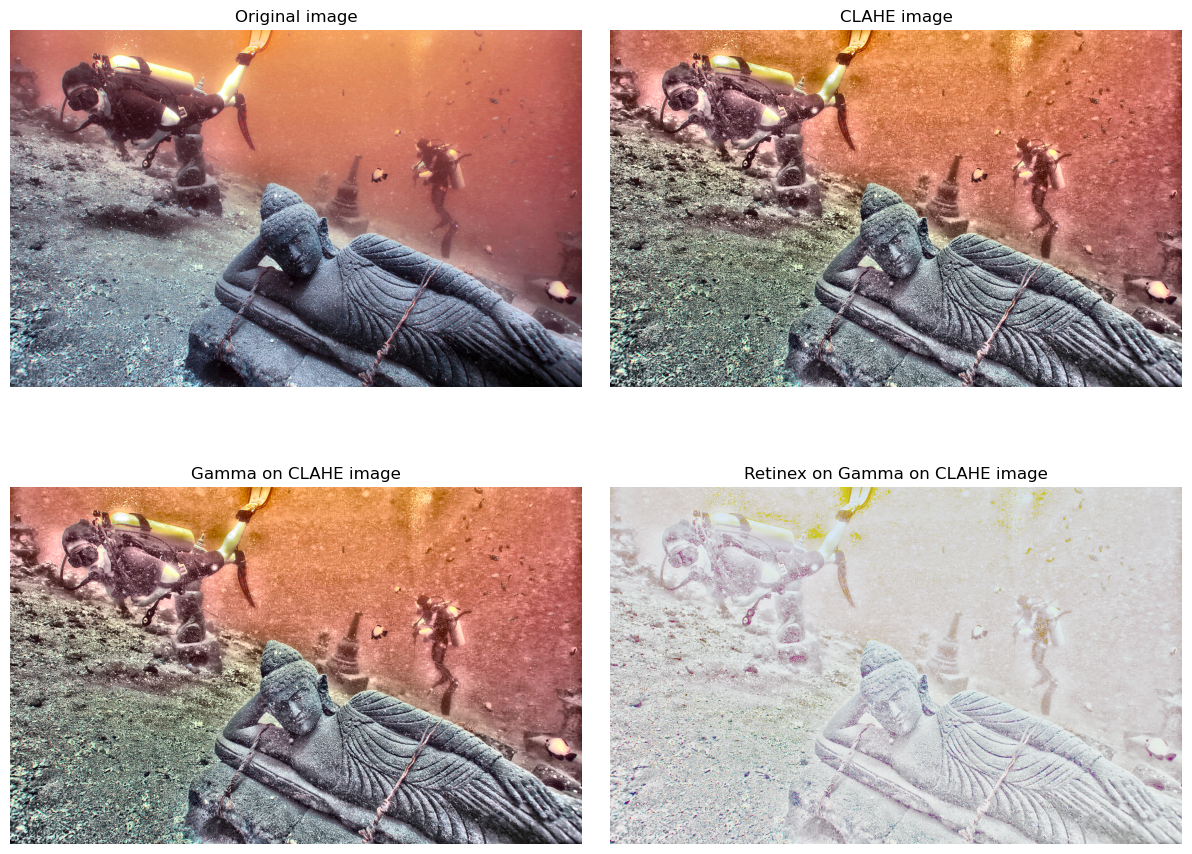

In [8]:
plot_img_4_pair(
    img_bgr,
    enhanced_img,
    gamma_corrected_img,
    retinex_img,
    title1="Original image",
    title2="CLAHE image",
    title3="Gamma on CLAHE image",
    title4="Retinex on Gamma on CLAHE image",
)

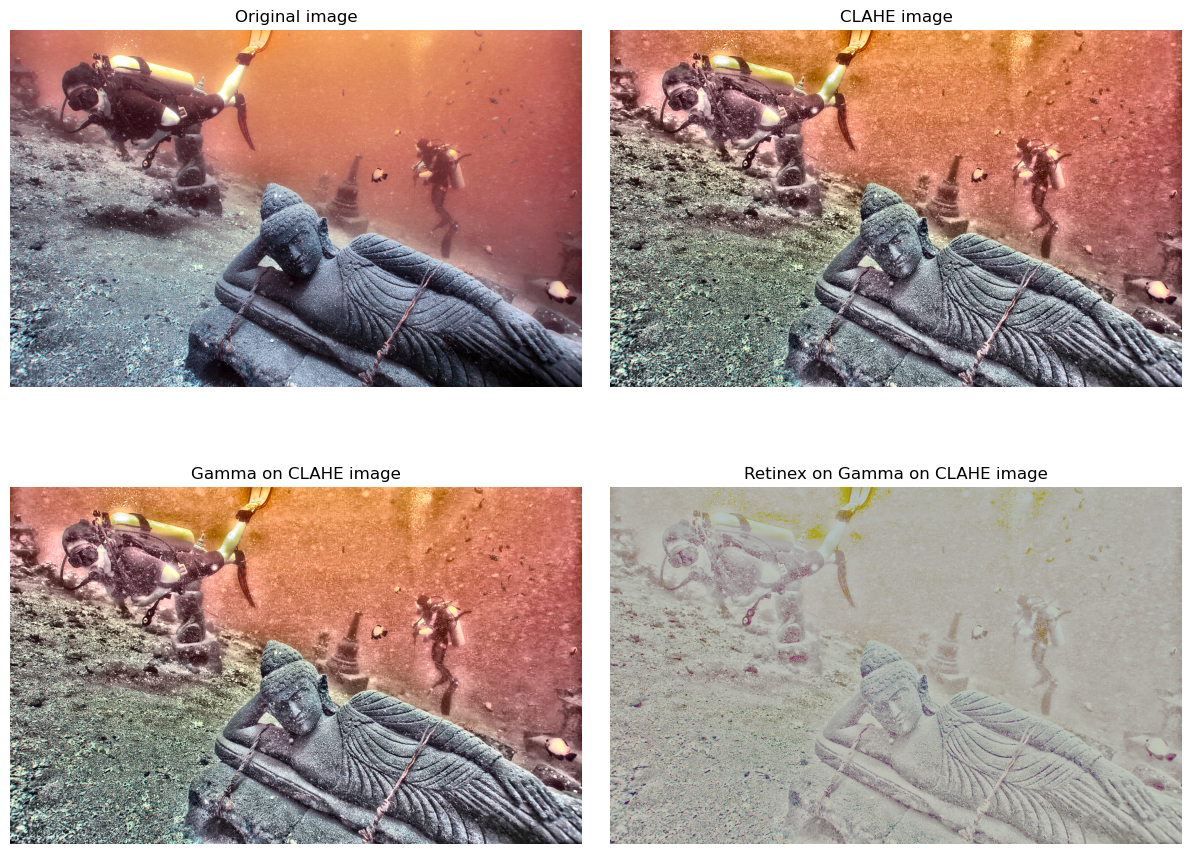

In [10]:
def multi_scale_retinex_v2(img, scales=[15, 80, 150], weights=[0.33, 0.33, 0.34]):
    img = img.astype(np.float32) + 1.0
    retinex = np.zeros_like(img)

    for s, w in zip(scales, weights):
        blur = cv2.GaussianBlur(img, (0, 0), sigmaX=s, sigmaY=s)
        retinex += w * (np.log10(img) - np.log10(blur + 1.0))

    for c in range(3):
        ch = retinex[:, :, c]
        ch = (ch - np.min(ch)) / (np.max(ch) - np.min(ch))
        retinex[:, :, c] = np.clip(ch * 255, 0, 255)

    retinex = np.uint8(retinex)
    retinex = cv2.convertScaleAbs(retinex, alpha=0.8, beta=0)
    return retinex

plot_img_4_pair(
    img_bgr,
    enhanced_img,
    gamma_corrected_img,
    multi_scale_retinex_v2(gamma_corrected_img),
    title1="Original image",
    title2="CLAHE image",
    title3="Gamma on CLAHE image",
    title4="Retinex on Gamma on CLAHE image",
)